In [1]:
import librosa
import numpy as np
import pandas as pd
from pydub import AudioSegment, effects
import os

import speech_recognition as src
from pydub.silence import split_on_silence

/Users/usama/anaconda3/lib/python3.10/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
import wavio as wv
from scipy.io.wavfile import write, read
import sounddevice as sd
import matplotlib.pyplot as plt

In [3]:
def _read_wav(wave_file):
	# Read the input
	rate, data = read(wave_file)
	channels = len(data.shape)
	filename = wave_file

	# Convert to mono
	if channels == 2 :
		data = np.mean(data, axis=1, dtype=data.dtype)
		channels = 1
	return data

read_file = _read_wav('/Users/usama/Downloads/voice/test3.wav')

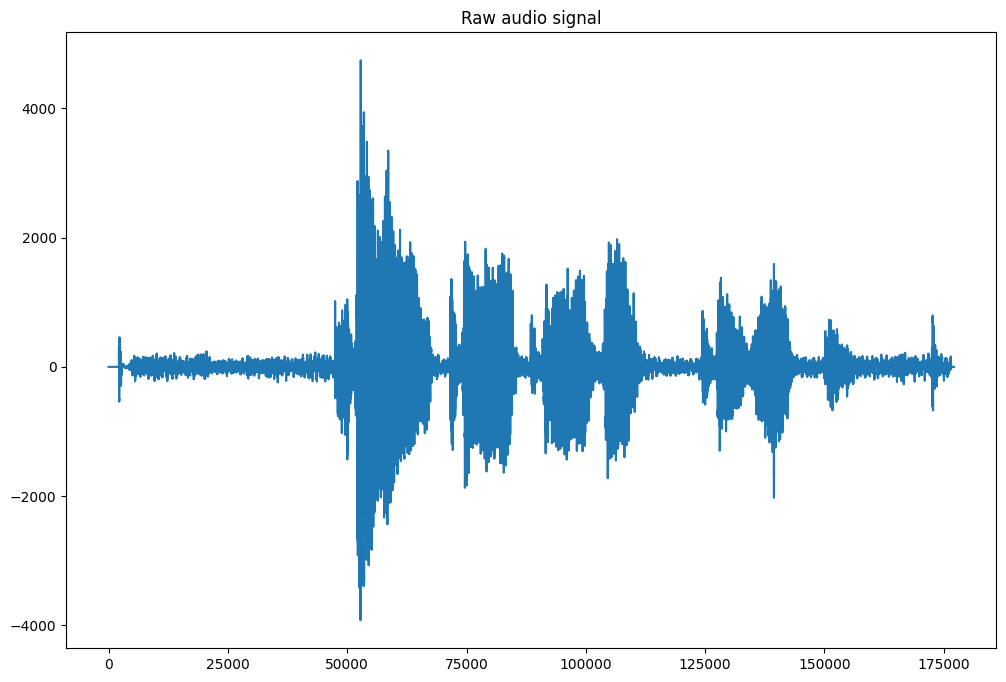

In [4]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(len(read_file)), read_file)
plt.title("Raw audio signal")
plt.show()

In [5]:
from keras.models import load_model
model = load_model('/Users/usama/Downloads/voice/my_model_weights_50epo_female.h5')

In [6]:
def preprocess_audio(path):
    _, sr = librosa.load(path)
 
    raw_audio = AudioSegment.from_file(path)
    
    samples = np.array(raw_audio.get_array_of_samples(), dtype='float32')
    trimmed, _ = librosa.effects.trim(samples, top_db=25)
    padded = np.pad(trimmed, (0, 180000-len(trimmed)), 'constant')
    return padded, sr

In [7]:
freq = 44100

duration = 5
recording = sd.rec(int(duration * freq), samplerate=freq, channels=1)

# Record audio for the given number of seconds
sd.wait()
write("recording0.wav", freq, recording)
wv.write("recording1.wav", recording, freq, sampwidth=2)

In [8]:
test_path = '/Users/usama/Downloads/voice/test3.wav'
dff = pd.DataFrame([test_path], columns=['path']),
df = pd.concat(dff, axis=1)
df

,path
0,/Users/usama/Downloads/voice/test3.wav


In [9]:
zcr_list = []
rms_list = []
mfccs_list = []


FRAME_LENGTH = 2048
HOP_LENGTH = 512

for index, row in df.iterrows():
    try:
        
        y, sr = preprocess_audio(row.path)
        zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=HOP_LENGTH)

        zcr_list.append(zcr)
        rms_list.append(rms)
        mfccs_list.append(mfccs)

        
    except:
        print(f"Failed for path: {row.path}")


In [10]:
try:
    X_test = np.concatenate((
        np.swapaxes(zcr_list, 1, 2), 
        np.swapaxes(rms_list, 1, 2), 
        np.swapaxes(mfccs_list, 1, 2)), 
        axis=2
    )
    X_test = X_test.astype('float32')
    y_pred = np.argmax(model.predict(X_test), axis=1)
    print(model.predict(X_test))
    
    
except:
    print("no data have been passed")

1/1 [==============================] - 0s 27ms/step
[[0.01745899 0.02261871 0.63801605 0.00470942 0.0218602  0.29533666]]


In [11]:
y_pred


array([2])

In [12]:
emotion_dic = {
    'neutral' : 0,
    'happy'   : 1,
    'sad'     : 2, 
    'angry'   : 3, 
    'fear'    : 4, 
    'disgust' : 5
}
#emotion_dic.items()
list(emotion_dic.keys())[list(emotion_dic.values()).index(int(y_pred))]

'sad'

In [13]:
r = src.Recognizer()
def transcribe_audio(path):
    # use the audio file as the audio source
    with src.AudioFile(path) as source:
        audio_listened = r.record(source)
        # try converting it to text
        text = r.recognize_google(audio_listened)
    return text

In [14]:

def get_large_audio_transcription_on_silence(path):
    """Splitting the large audio file into chunks
    and apply speech recognition on each of these chunks"""
    # open the audio file using pydub
    sound = AudioSegment.from_file(path)  
    # split audio sound where silence is 500 miliseconds or more and get chunks
    chunks = split_on_silence(sound,
        # experiment with this value for your target audio file
        min_silence_len = 500,
        # adjust this per requirement
        silence_thresh = sound.dBFS-14,
        # keep the silence for 1 second, adjustable as well
        keep_silence=500,
    )
    folder_name = "audio-chunks"
    # create a directory to store the audio chunks
    if not os.path.isdir(folder_name):
        os.mkdir(folder_name)
    whole_text = ""
    # process each chunk 
    for i, audio_chunk in enumerate(chunks, start=1):
        # export audio chunk and save it in
        # the `folder_name` directory.
        chunk_filename = os.path.join(folder_name, f"chunk{i}.wav")
        audio_chunk.export(chunk_filename, format="wav")
        # recognize the chunk
        try:
            text = transcribe_audio(chunk_filename)
        except src.UnknownValueError as e:
            print("Error:", str(e))
        else:
            text = f"{text.capitalize()}. "
            print(chunk_filename, ":", text)
            whole_text += text
    # return the text for all chunks detected
    return whole_text

In [16]:
while True:
    freq = 44100
    duration = 5
    zcr_list = []
    rms_list = []
    mfccs_list = []


    recording = sd.rec(int(duration * freq), samplerate=freq, channels=1)
    sd.wait()
    write("recording0.wav", freq, recording)
    wv.write("recording1.wav", recording, freq, sampwidth=2)
    

    test_path = '/Users/usama/Downloads/voice/recording1.wav'
    print("\nFull text:", get_large_audio_transcription_on_silence(test_path))
    dff = pd.DataFrame([test_path], columns=['path']),
    df = pd.concat(dff, axis=1)
    
    
    FRAME_LENGTH = 2048
    HOP_LENGTH = 512

    for index, row in df.iterrows():
        try:
            
            y, sr = preprocess_audio(row.path)
            zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
            rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=HOP_LENGTH)

            zcr_list.append(zcr)
            rms_list.append(rms)
            mfccs_list.append(mfccs)

            
        except:
            print(f"Failed for path: {row.path}")
    
    try:
        X_test = np.concatenate((
            np.swapaxes(zcr_list, 1, 2), 
            np.swapaxes(rms_list, 1, 2), 
            np.swapaxes(mfccs_list, 1, 2)), 
            axis=2
        )
        X_test = X_test.astype('float32')
        y_pred = np.argmax(model.predict(X_test), axis=1)
    except:
        print("no data have been passed")
    
    emotion_dic = {
        'neutral' : 0,
        'happy'   : 1,
        'sad'     : 2, 
        'angry'   : 3, 
        'fear'    : 4, 
        'disgust' : 5
    }
    
    print(list(emotion_dic.keys())[list(emotion_dic.values()).index(int(y_pred))])

Error: 
Error: 
audio-chunks/chunk3.wav : Scarify. 

Full text: Scarify. 
Failed for path: /Users/usama/Downloads/voice/recording1.wav
no data have been passed


TypeError: only size-1 arrays can be converted to Python scalars